<a href="https://colab.research.google.com/github/rzuberi/cell-SCT/blob/main/Cell_segmentation_implementing_CellPose2_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Digitally segmenting cells in two channels

This notebook serves as a walkthrough to segment cells out of microscopy pictures. Using CellPose2, this notebook will help you create a machine learning model tailored to your segmentation needs. The output from this notebook will be nuclei masks for each of your cell microscopy pictures, and a machine learning model that can segment more out. Eventually, this notebook will segment each cell out of your microscopy pictures.

Method
1. Upload all of your cell images. 5 will be randomly selected to be hand-labelled to create our segmentation model. 5 others (that will be different from the first set) will be randomly selected to be hand-labelled to test the accuracy of our first model.
2. We will check the accuracy of our model using our second set.
3. We will generate the cell masks of all of our cell microscopy images.

#1. Uploading your data and selecting the training and testing images



Our data should be one multi-page TIFF file. If you have other TIFF files that have similar cells and that you also want to create masks for, we will show you how to do that later.

The next cell will create a directory called **data** on the left-side of your notebook in the 'Files' section.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os #package that lets us do folder & file manipulations
os.makedirs('data') #creating the directory

In that folder, you need to add your multi-page TIFF file that should contain your cell images.

We will now split the multi-page TIFF file by channel. This will provide the individual images which is important for random training and testing data splitting later on.

In [ ]:
import os
os.chdir("/content/drive/My Drive/UNI/JRA/JRA Project/Cell images (7 06 22)")
!ls

 content			    data_splitted
'Copy of PCNA_SirDNA_01.ome.tiff'   PCNA_SirDNA_01.ome.tiff
 data_for_masks_testing.zip	    PCNA_SirDNA_02.ome.tiff
 data_for_masks.zip		    user_created_masks_and_model


In [ ]:
#Splitting images into channel_0 and channel_1 directories

from PIL import Image, ImageSequence #package for image manipulation

#Creating the directories
os.makedirs('/content/data_splitted')
os.makedirs('/content/data_splitted/channel_0')
os.makedirs('/content/data_splitted/channel_1')

#Putting image in relevant directories
img = Image.open('/content/drive/My Drive/UNI/JRA/JRA Project/Cell images (7 06 22)/PCNA_SirDNA_01.ome.tiff')
iter = 0 #to alternate between folders
item_num_1 = 0
item_num_2 = 0
for i, page in enumerate(ImageSequence.Iterator(img)):
  if iter%2==0:
    page.save("/content/data_splitted/channel_0/C0_Image%d.tiff" % item_num_1)
    item_num_1 += 1
  else:
    page.save("/content/data_splitted/channel_1/C1_Image%d.tiff" % item_num_2)
    item_num_2 += 1
  iter += 1

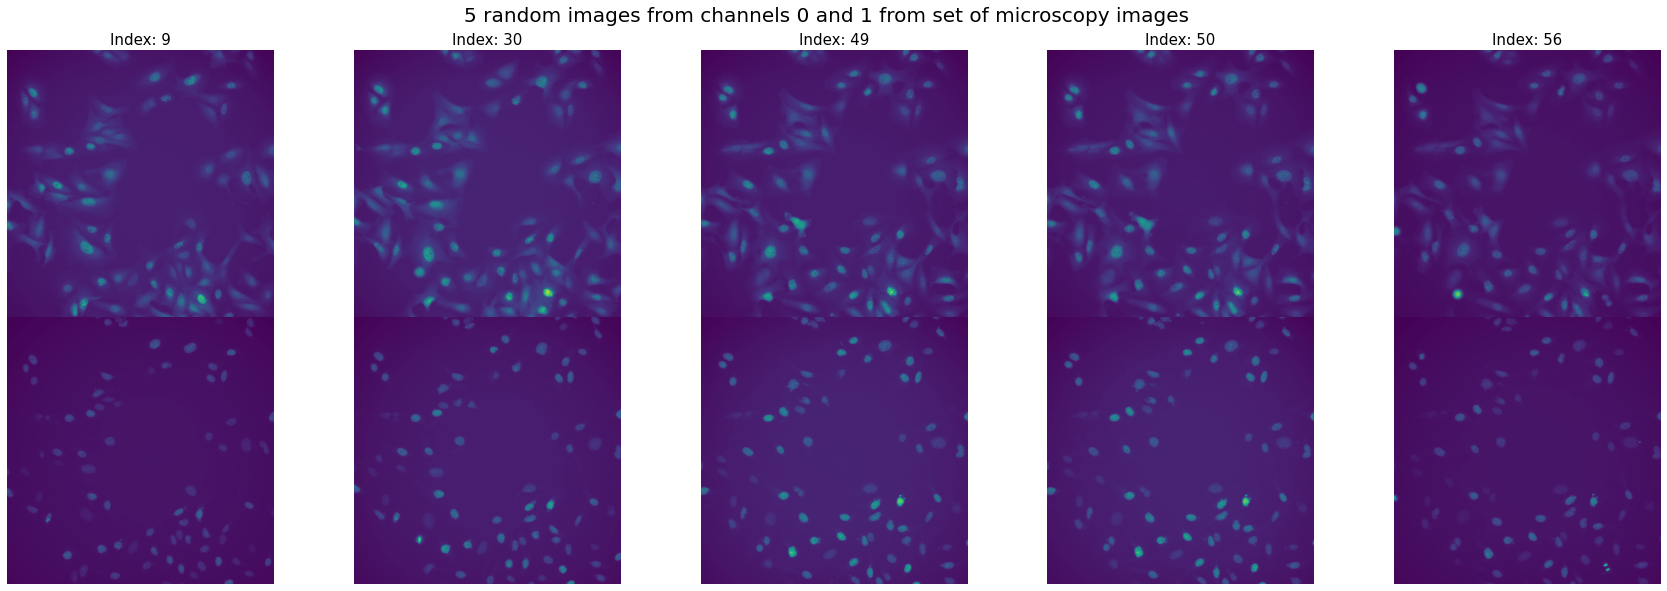

In [ ]:
#Display 5 random images from directory

#First need to get the size of the folder
num_imgs = len([entry for entry in os.listdir('/content/data_splitted/channel_0') if os.path.isfile(os.path.join('/content/data_splitted/channel_0', entry))])

from matplotlib import pyplot as plt
import random
from random import randint

indices = random.sample(range(num_imgs), 5)
indices.sort()

#Plotting images from channel 0
fig, ax = plt.subplots(figsize=(24,8))
fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.suptitle("5 random images from channels 0 and 1 from set of microscopy images", y=1.05, fontsize=20)
plt.text(y=40,x=10,s='GUIDUIGUD')
for i in range(5):
  #subplot_num = 251
  plt.subplot(2,5,i+1)
  img_path = '/content/data_splitted/channel_0/C0_Image' + str(indices[i]) + '.tiff'
  img = Image.open(img_path)
  plt.axis('off')
  plt.title('Index: ' + str(indices[i]),fontdict={'fontsize':15})
  plt.imshow(img)
#plt.show()

#Plotting images from channel 1
#fig = plt.figure(figsize=(30,30))
#fig.suptitle("5 random images from the channel 1 set of microscopy images", y=0.59, fontsize=20)
for i in range(5):
  #subplot_num = 251
  plt.subplot(2,5,i+6)
  img_path = '/content/data_splitted/channel_1/C1_Image' + str(indices[i]) + '.tiff'
  img = Image.open(img_path)
  plt.axis('off')
  #plt.title('Index: ' + str(indices[i]))
  plt.imshow(img)

plt.show()

Now that we have our data in the right format, we will generate the training data and our model at the same time. This will work with CellPose2.

In our dataset, we want our model to segment the nucleis out of the channel 0 images. The channel 1 images have the nucleis. Therefore, we use the channel 1 images to create our groundtruth data. These will be masks that we will create with CellPose2.

Method to create ground truth data and human-in-the-loop model
1. Get 5 random indices that correspond to images in channel 0 and channel 1
2. Dowload the corresponding images in channel 1
3. In the downloaded folder of images, open the first image in CellPose2
4. Select the 'nuclei' pre-trained model and make necessary corrections to the model's predictions
5. Go into 'File' at the top of CellPose2 and choose the option to train a model based on the data provided; name your model 'nuclei_segmentation_model'. 
6. This will go to the next image in the folder and make predictions that you have to correct again.
7. Once all the images have been segmented, you can upload the entire folder in the notebook's folder called 'user_created_masks_and_model'. Do not change any names of the files you are uploading. (we'll make the code to extract the masks and the created model from that folder. we also need to display the masks created by the user).

This next cell does step 1 and 2 of the above method description. It will automatically download the images you will have to manually correct the labelling of in a human-in-the-loop system with CellPose2.

In [ ]:
#Generate the 5 random indices

indices = random.sample(range(num_imgs), 5)
indices.sort()
indices = [18,46,52,68,71]

#Move the corresponding images from channel 0 into a folder
os.makedirs('/content/data_for_masks')
import shutil
for i in range(len(indices)):
  src = '/content/data_splitted/channel_1/C1_Image' + str(indices[i]) + '.tiff'
  dst = '/content/data_for_masks/C1_Image' + str(indices[i]) + '.tiff'
  shutil.copyfile(src,dst)

In [ ]:
#Download the training images
!zip -r data_for_masks.zip /content/data_for_masks
from google.colab import files
files.download("data_for_masks.zip")

updating: content/data_for_masks/ (stored 0%)
updating: content/data_for_masks/C1_Image18.tiff (deflated 24%)
updating: content/data_for_masks/C1_Image46.tiff (deflated 23%)
updating: content/data_for_masks/C1_Image52.tiff (deflated 23%)
updating: content/data_for_masks/C1_Image68.tiff (deflated 23%)
updating: content/data_for_masks/C1_Image71.tiff (deflated 22%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Create the folder 'user_created_masks_and_model'
os.makedirs('/content/user_created_masks_and_model')

#Explain that the folder call 'data_for_masks' has to be uploaded in the 'user_created_masks_and_model' folder

Here we need to write a tutorial, with images with arrows on them, that goes through how to use CellPose2 to generate the model and the groundtruth data.
```
conda create --name cellpose python=3.8
y
y
conda activate cellpose
python -m pip install cellpose[gui]
python -m cellpose
```

After that, we need to explain how to upload the folder. It should be very straightforward as the code will do the work of extracting the model and the groundtruth images from the folder that they upload. We will display the images they were given and the corresponding masks they created.

In [ ]:
#Have to unzip the file in user_created_masks_and_model
import zipfile
with zipfile.ZipFile('/content/user_created_masks_and_model/data_for_masks.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/user_created_masks_and_model')

In [ ]:
#These indices were put here because it was the current data we had made the segmentation for but the indices list had changed since then and it took too long just for testing to redo the data again
#The indicides list has to change name to be clear that its the training set indices, 'training_set_indices' has a ring to it
indices = [18,46,52,68,71]

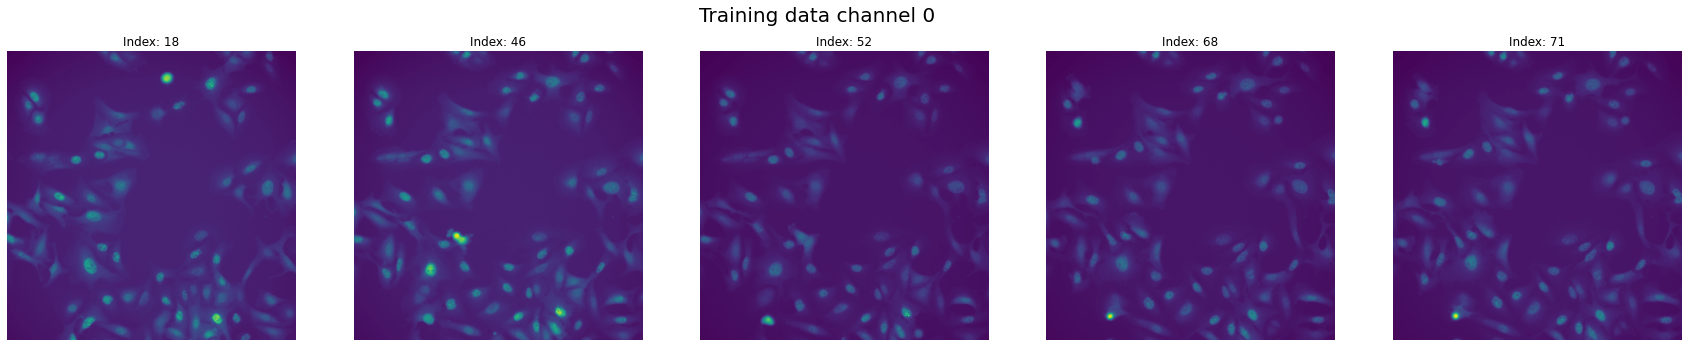

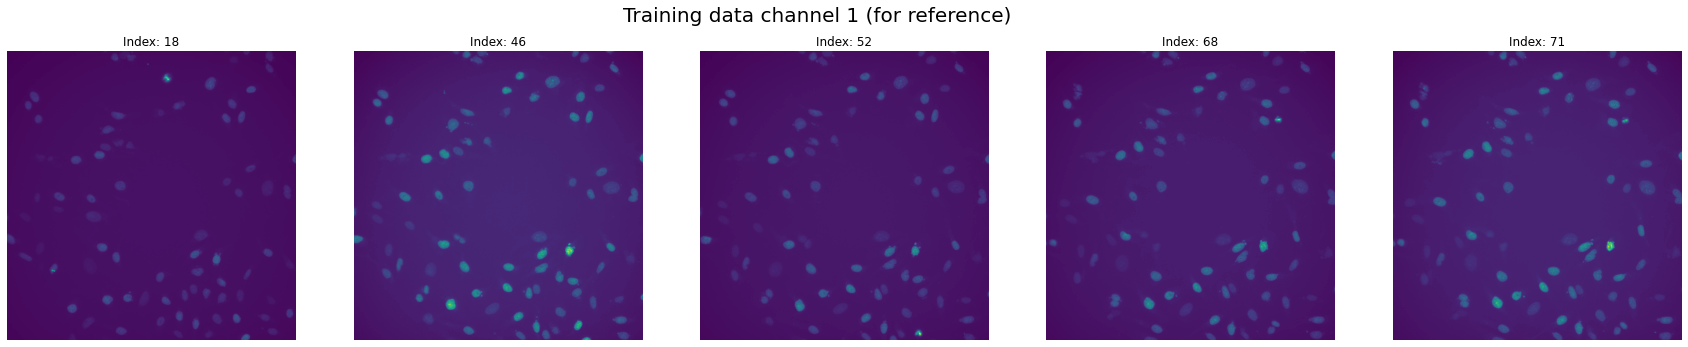

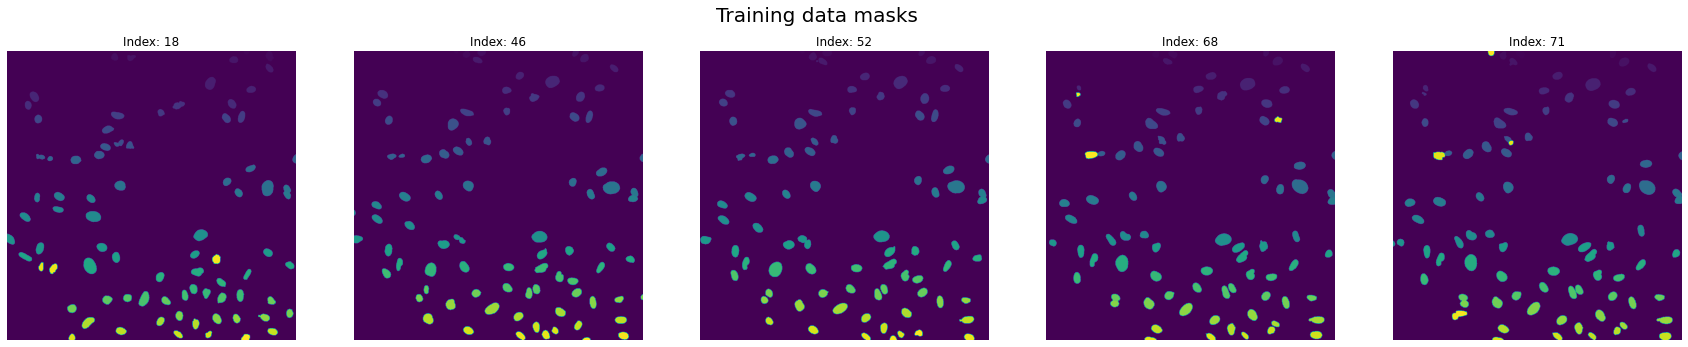

In [ ]:
import numpy as np

fig = plt.figure(figsize=(30,30))
fig.suptitle("Training data channel 0", y=0.59, fontsize=20)
for i in range(5):
  subplot_num = 151
  plt.subplot(subplot_num+i)
  img_path = '/content/data_splitted/channel_0/C0_Image' + str(indices[i]) + '.tiff'
  img = Image.open(img_path)
  plt.axis('off')
  plt.title('Index: ' + str(indices[i]))
  plt.imshow(img)
plt.show()

#Plotting images from channel 1
fig = plt.figure(figsize=(30,30))
fig.suptitle("Training data channel 1 (for reference)", y=0.59, fontsize=20)
for i in range(5):
  subplot_num = 151
  plt.subplot(subplot_num+i)
  img_path = '/content/data_splitted/channel_1/C1_Image' + str(indices[i]) + '.tiff'
  img = Image.open(img_path)
  plt.axis('off')
  plt.title('Index: ' + str(indices[i]))
  plt.imshow(img)
plt.show()

#Plotting the masks
from PIL import Image
fig = plt.figure(figsize=(30,30))
fig.suptitle("Training data masks", y=0.59, fontsize=20)
for i in range(5):
  subplot_num = 151
  plt.subplot(subplot_num+i)
  path = '/content/user_created_masks_and_model/data_for_masks/content/data_for_masks/C1_Image' + str(indices[i]) + '_seg.npy'
  seg = np.load(path, allow_pickle=True).item()
  masks= seg['masks'].squeeze()
  plt.imshow(masks)
  plt.axis('off')
  plt.title('Index: ' + str(indices[i]))
plt.show()

In [ ]:
print(len(masks))
print(masks.shape)

1080
(1080, 1080)


In [ ]:
current_mask = masks

lines_with_cell = 0
numbers_found = []

for i in range(len(current_mask)):
  #if in one line of pixels there are only zeros, then there are no cells in that line
  current_line = current_mask[i]
  if not np.all((current_line == 0)):
    for j in range(len(current_line)):
      if current_line[j] != 0: numbers_found.append(current_line[j])

print(lines_with_cell) #number of lines where at least one cell appears
print(len(set(numbers_found))) #number of rois, and pixel value of each cell
print(len(current_mask))

0
87
1080


In [ ]:
import cv2

In [ ]:
plt.imshow(current_mask,cmap='gray')

In [ ]:
print(current_mask.shape)

(1080, 1080)


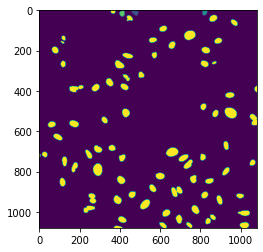

In [ ]:
#needs to be multipled by 255 since they are between 0 and 1 right now
#current_mask = np.copy(current_mask)*255
ret, thresh1 = cv2.threshold(current_mask, 4,4 , cv2.THRESH_TRUNC)
plt.imshow(thresh1)

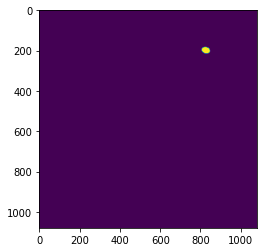

In [ ]:
nuclei_num = 15 #background is 0, cells start at 1
image = np.copy(current_mask)
binary = [[True if num==nuclei_num else False for num in row ] for row in image]
plt.imshow(binary)
plt.show()

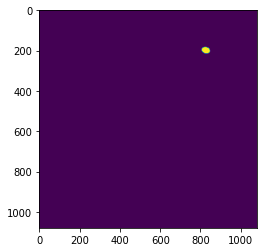

In [ ]:
nuclei_num = 15 #background is 0, cells start at 1
image = np.copy(current_mask)
binary = np.copy(image)

binary = binary == nuclei_num

plt.imshow(binary)
plt.show()

In [ ]:
top_left_col, top_left_row = None, None
bot_right_col, bot_right_row = None, None

#Get the first True's row and column (top left)
for i in range(len(binary)):
  if True in binary[i]:
    top_left_row = i
    for j in range(len(binary[i])):
      if binary[i][j] == True:
        top_left_col = j
        break
  if top_left_row != None and top_left_col != None: break

#Get the last True's row and column (bottom right)
for i in range(len(binary)):
  if True in binary[i]:
    bot_right_row = i
    for j in range(len(binary[i])):
      if binary[i][j] == True:
        bot_right_col = j

#Start reading from the columns (top right)
top_right_col, top_right_row = None, None
for i in range(len(binary)):
  if True in binary[i]:
    print('yy')
    top_right_row = i
    for j in range(len(binary[i])):
      if binary[i][j] == True:
        top_right_col = j        
  if top_right_row != None and top_right_col != None: break

bot_left_col, bot_left_row = None, None
for i in range(len(binary)):
  if True in binary[i]:
    while True in binary[i]: i+=1
    bot_left_row = i-1
    for j in range(len(binary[bot_left_row])):
      if binary[bot_left_row][j]:
        bot_left_col = j
        break
  if bot_left_row != None: break

    #bot_right_row = i
    #for j in range(len(binary[i])):
     # if binary[i][j] == True:
        #bot_right_col = j

print(top_left_col,top_left_row)
print(bot_right_col, bot_right_row)
print(top_right_col,top_right_row)
print(bot_left_col, bot_left_row)

yy
819 183
834 214
828 183
824 214


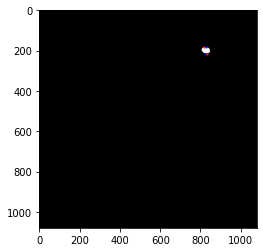

In [ ]:
#add a diagonal between the points (to make a cross)
plt.imshow(binary,cmap='gray')
plt.scatter(top_left_col,top_left_row,c='r',s=1)
plt.scatter(bot_right_col,bot_right_row,c='r',s=1)
plt.scatter(top_right_col,top_right_row,c='b',s=1)
plt.scatter(bot_left_col,bot_right_row,c='b',s=1)


826 198


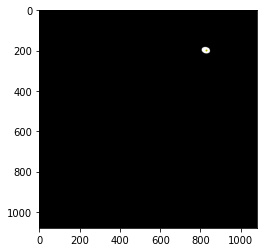

In [ ]:
#Get center of 4 points, that will be the center of the cell
x_coors = [top_left_col,bot_right_col,top_right_col,bot_left_col]
y_coors = [top_left_row,bot_right_row,top_right_row,bot_right_row]
center_col = int(sum(x_coors)/len(y_coors))
center_row = int(sum(y_coors)/len(y_coors))
print(center_col,center_row)
plt.imshow(binary,cmap='gray')
plt.scatter(center_col,center_row,c='y',s=1)

34.438350715445125 31.25699921617557


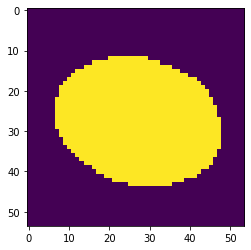

In [ ]:
#Getting the crop
#The length of the side of the crop should be the longest diagonal of the cell + 10 pixels
import math
from math import hypot
diag1_len = math.hypot(bot_right_col - top_left_col, bot_right_row - top_left_row)
diag2_len = math.hypot(bot_left_col - top_right_col, bot_left_row - top_right_row)
print(diag1_len,diag2_len)
if diag1_len > diag2_len: crop_len = diag1_len
else: crop_len = diag2_len
crop_len = int(crop_len/2)+10

cropped_img = np.copy(binary)
#rows,columns
cropped_img = cropped_img[center_row-crop_len:center_row+crop_len,center_col-crop_len:center_col+crop_len]
plt.imshow(cropped_img)

In [ ]:
#Function to get the number of cells in an image
#Input: image
#Output: number of cells
#The number of cells is defined by the number of different pixel intensities, excluding the background

def count_cells(img):
  numbers_found = []

  for i in range(len(current_mask)):
    #if in one line of pixels there are only zeros, then there are no cells in that line
    current_line = current_mask[i]
    if not np.all((current_line == 0)):
      for j in range(len(current_line)):
        if current_line[j] != 0: numbers_found.append(current_line[j])
  return len(set(numbers_found))

In [ ]:
#Function to get the 4 coordinates of cell
#Input: binary image where cell is singled out
#Output: list withtop left coordinates, bottom left coordinates, top right coordinates, bottom right coordinates

def get_corners(binary):
  top_left_col, top_left_row = None, None
  bot_right_col, bot_right_row = None, None
  top_right_col, top_right_row = None, None
  bot_left_col, bot_left_row = None, None

  #Get the first True's row and column (top left)
  for i in range(len(binary)):
    if True in binary[i]:
      top_left_row = i
      for j in range(len(binary[i])):
        if binary[i][j] == True:
          top_left_col = j
          break
    if top_left_row != None and top_left_col != None: break

  #(bottom left)
  for i in range(len(binary)):
    if True in binary[i]:
      while i < 1080 and True in binary[i]: i+=1
      bot_left_row = i-1
      for j in range(len(binary[bot_left_row])):
        if binary[bot_left_row][j]:
          bot_left_col = j
          break
    if bot_left_row != None: break

  #Get the last True's row and column (bottom right)
  for i in range(len(binary)):
    if True in binary[i]:
      bot_right_row = i
      for j in range(len(binary[i])):
        if binary[i][j] == True:
          bot_right_col = j

  #Start reading from the columns (top right)
  for i in range(len(binary)):
    if True in binary[i]:
      top_right_row = i
      for j in range(len(binary[i])):
        if binary[i][j] == True:
          top_right_col = j        
    if top_right_row != None and top_right_col != None: break
  
  #print('xxxxx')

  return [(top_left_col,top_left_row),(bot_left_col,bot_left_row),(top_right_col,top_right_row),(bot_right_col,bot_right_row)]

In [ ]:
#Function to get the center of a cell
#Input: 4 corners of a cell
#Output: coordinates of center of cell

def get_center(corners):

  x_coors = [corners[i][0] for i in range(4)]
  y_coors = [corners[i][1] for i in range(4)]
  center_col = int(sum(x_coors)/len(y_coors))
  center_row = int(sum(y_coors)/len(y_coors))

  return center_col,center_row

In [ ]:
#Function to get the longest diagonal
#Input: 4 coordinates of cell
#Output: longest line between two points
import math
from math import hypot
import itertools
from itertools import combinations

def get_longest_line(corners):
  point_combinations = sum([list(map(list, combinations(corners, i))) for i in range(len(corners) + 1)], [])
  point_combinations = [combi for combi in point_combinations if len(combi)==2]

  longest = 0
  test = []
  for combi in point_combinations:
    current_len = math.hypot(combi[0][0] - combi[1][0], combi[0][1] - combi[1][1])
    test.append(current_len)
    if current_len > longest: longest = current_len
  
  return int(longest)
#Should try every line length between every point, not just the cross diagonal

In [ ]:
#Function that takes a mask and returns a crop of every cell inside of it
#Input: image of cells (mask)
#Output: list of images that are crops of the cells in the inputted image

def get_cell_crop_coordinates(original_cells_img):
  copy_cells_img = np.copy(original_cells_img)

  #get the number of nucleis
  num_cells = count_cells(copy_cells_img)

  crops = []
  crop_coordinates = []

  #loop through the number of nucleis
  for nuclei_num in range(1,num_cells+1):
    #print(str(nuclei_num)+'/'+str(num_cells))

    #get singled out cell image
    cell_img = np.copy(copy_cells_img)
    cell_img = cell_img == nuclei_num

    corners = get_corners(cell_img) #get the four corners of the nuclei

    center_col, center_row = get_center(corners) #get the center of the nuclei

    margin = 10
    crop_len = int(get_longest_line(corners)/2)+margin #get the longest diag and divide by 2 for square crop half length

    bottom_row = max(0,center_row-crop_len)
    top_row = min(copy_cells_img.shape[0]-1,center_row+crop_len)
    bottom_col = max(0,center_col-crop_len)
    top_col = min(copy_cells_img.shape[1]-1,center_col+crop_len)
    
    crop_coordinates.append([bottom_row,top_row,bottom_col,top_col]) #store the crop coordinates

    crops.append(cell_img[bottom_row:top_row,bottom_col:top_col]) #make the crop and store it in the list
    
  return crop_coordinates

In [ ]:
crop_coordinates = get_cell_crop_coordinates(current_mask)

In [ ]:
#We can now get the crops of the groundtruth mask
#We now need to make a function to apply these masks
#That function will be useful to apply on the groundtruth image and the predicted image for qualitative comparison

In [ ]:
#Function to get crops on image from list of coordinates
#Input: original image, list of coordinates to crop around(4)
#Output: crops of these coordinates

def get_img_crops(img,list_of_coordinates):
  crops = [] #where the cropped images will be stored
  for coor in list_of_coordinates:
    crops.append(img[coor[0]:coor[1],coor[2]:coor[3]])
  return crops

In [ ]:
img_path = '/content/data_splitted/channel_1/C1_Image' + str(4) + '.tiff'
cells_image = cv2.imread(img_path)
#cells_image = Image.open(img_path)

img_crops = get_img_crops(cells_image,crop_coordinates)

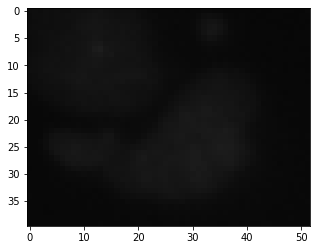

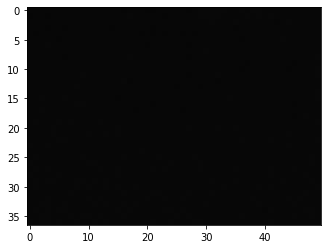

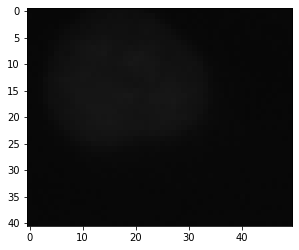

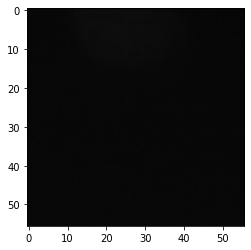

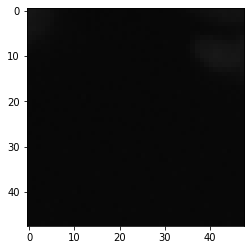

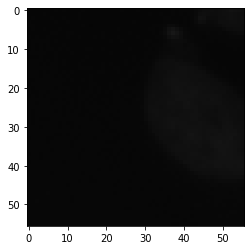

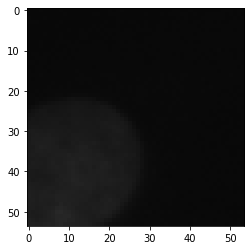

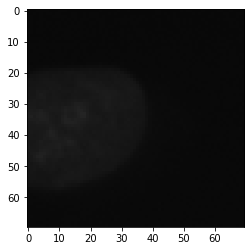

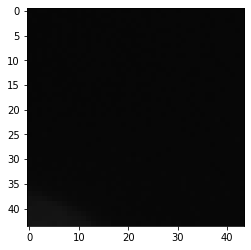

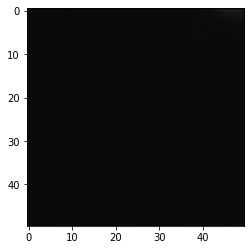

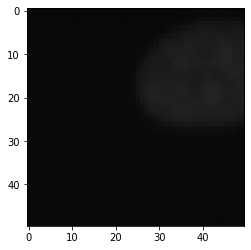

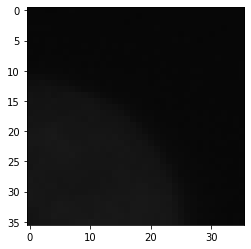

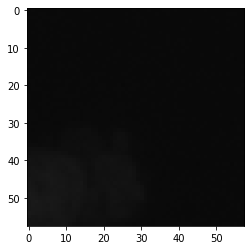

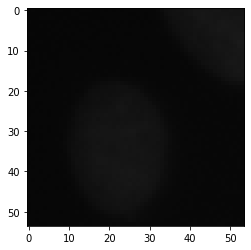

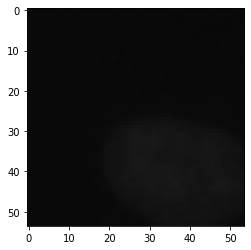

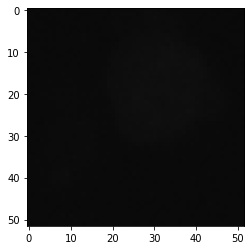

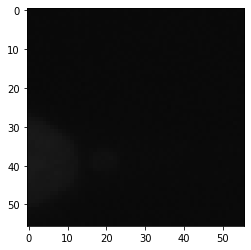

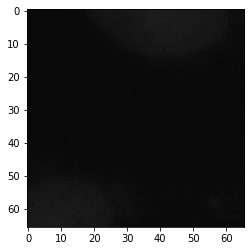

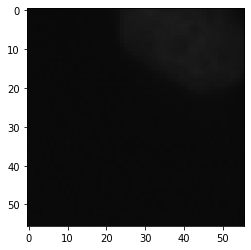

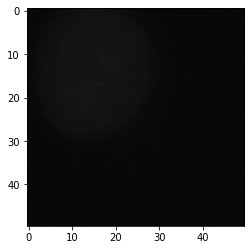

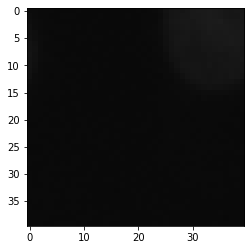

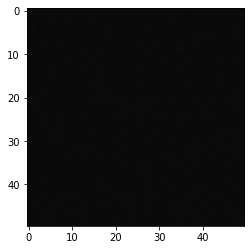

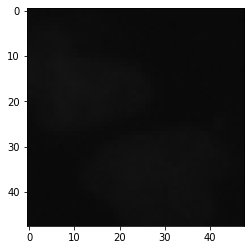

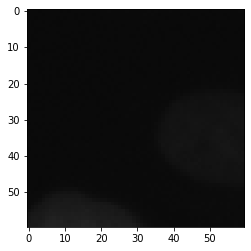

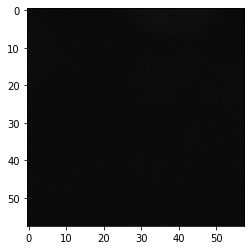

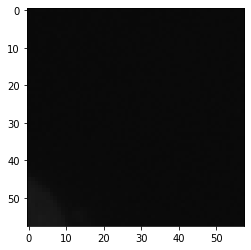

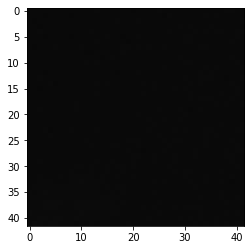

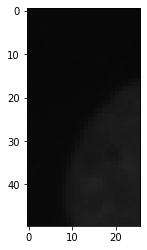

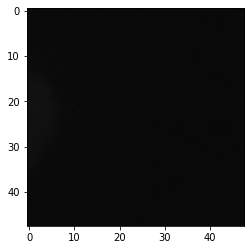

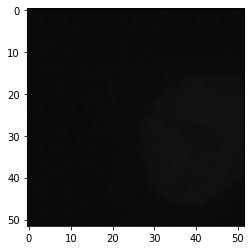

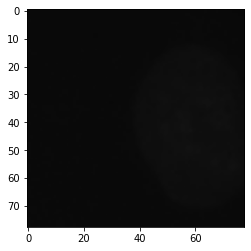

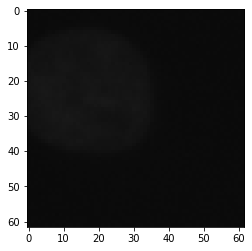

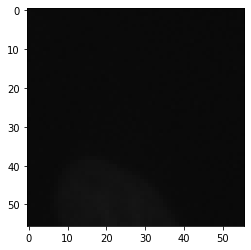

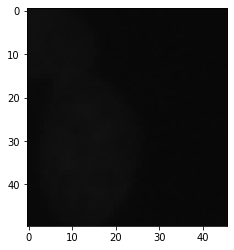

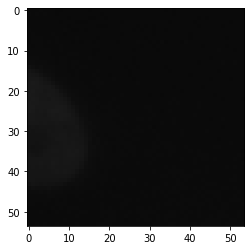

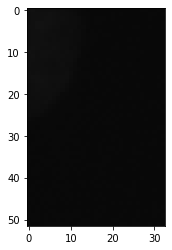

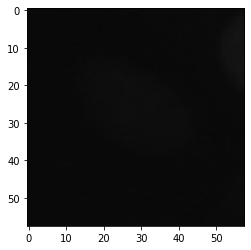

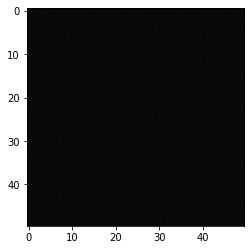

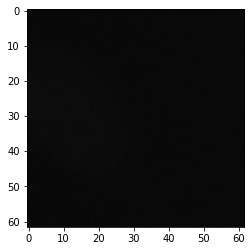

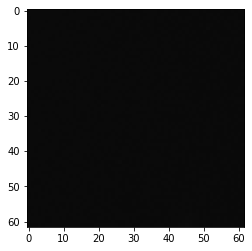

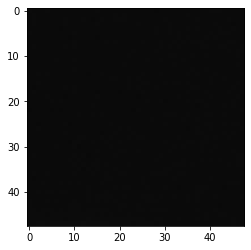

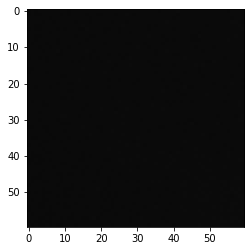

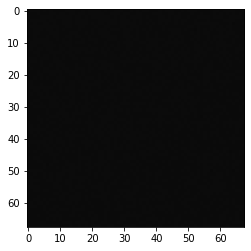

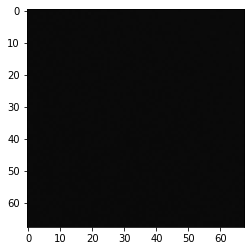

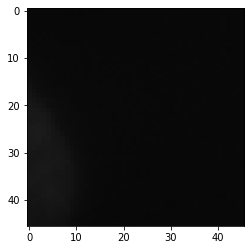

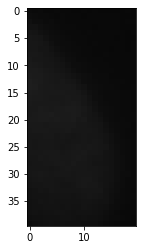

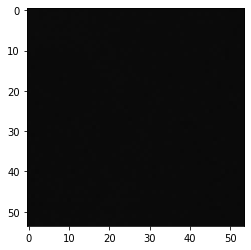

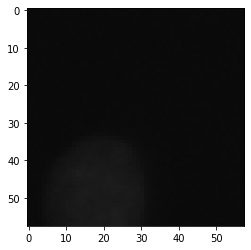

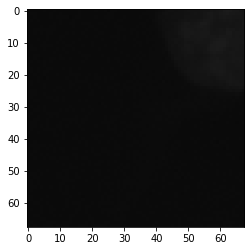

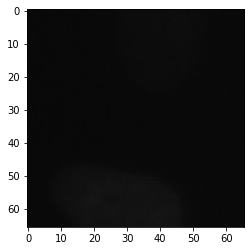

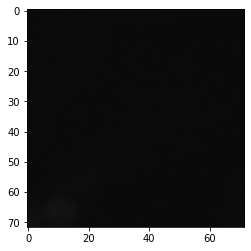

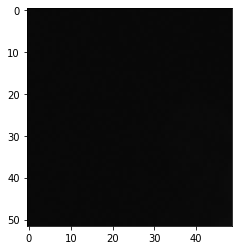

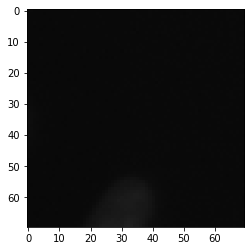

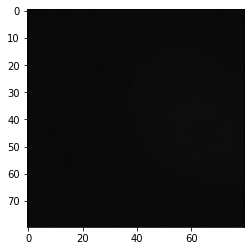

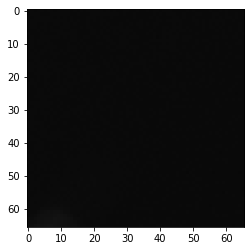

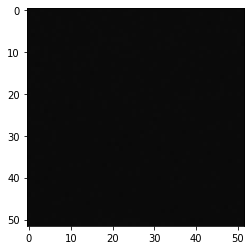

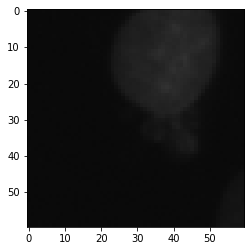

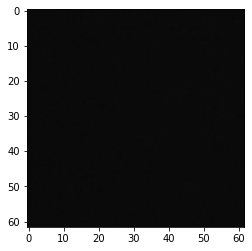

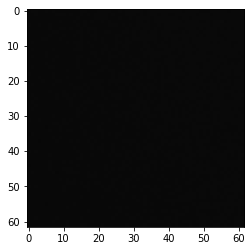

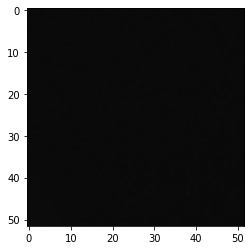

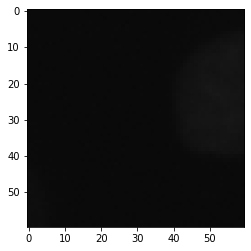

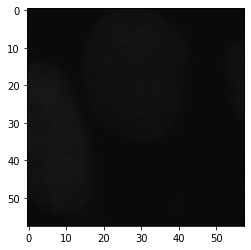

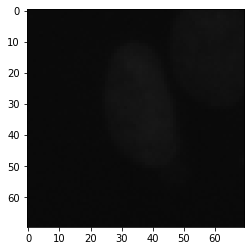

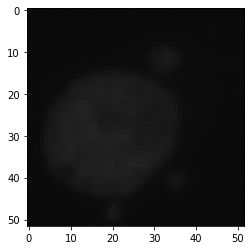

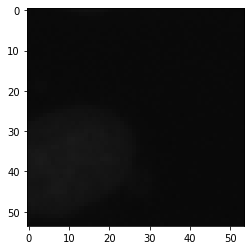

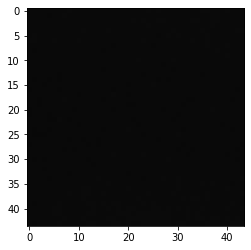

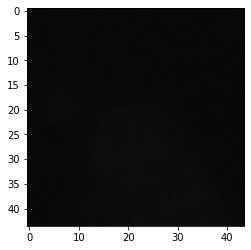

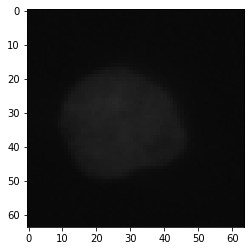

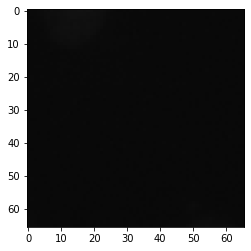

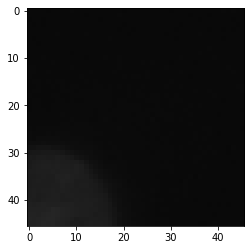

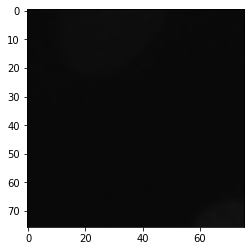

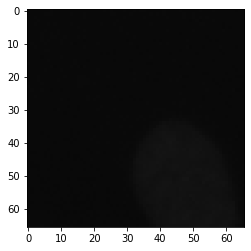

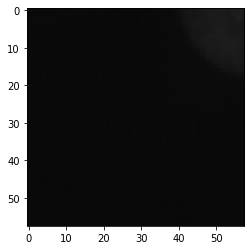

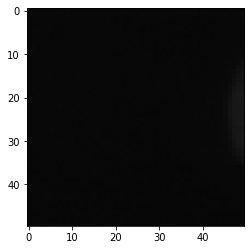

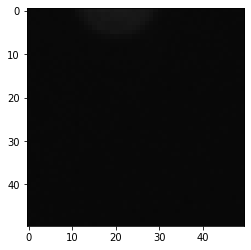

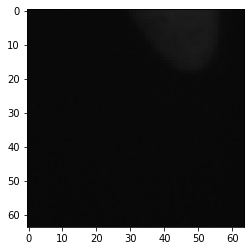

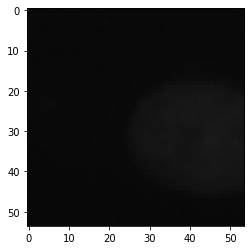

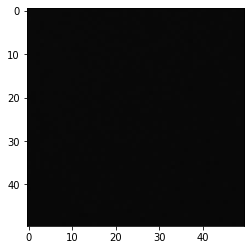

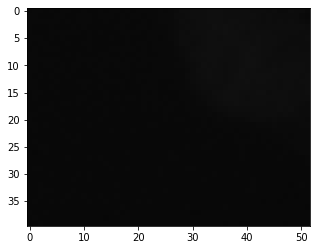

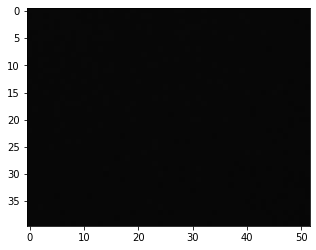

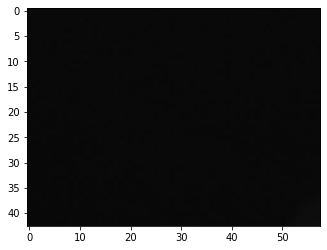

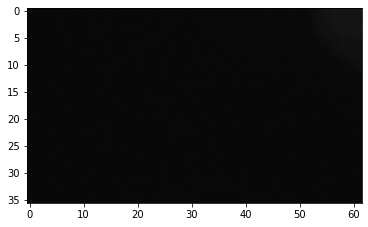

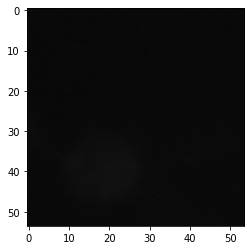

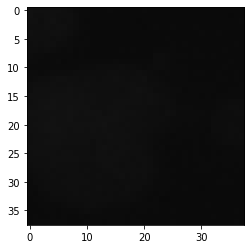

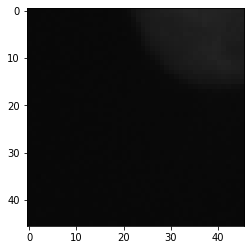

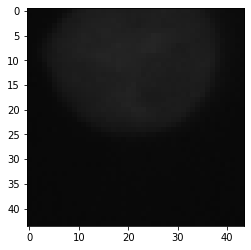

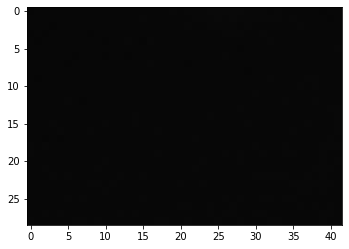

In [ ]:
#Displaying the crops on the original image, not the mask, so the actual cells

for img in img_crops:
  plt.imshow(img),plt.show()

In [ ]:
print(crop_coordinates[0])

[0, 40, 450, 502]


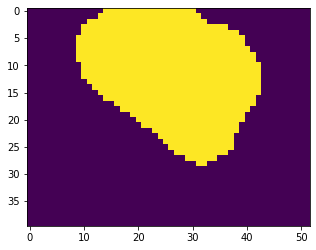

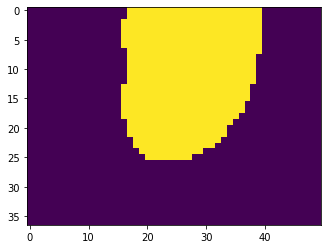

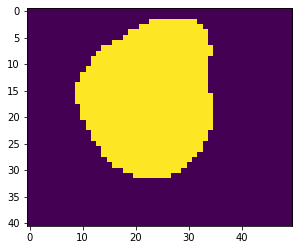

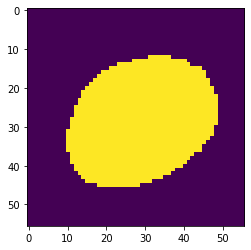

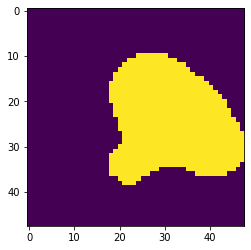

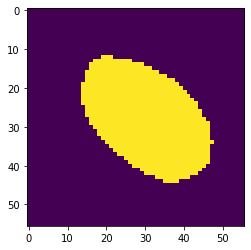

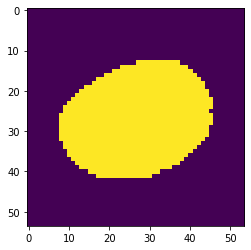

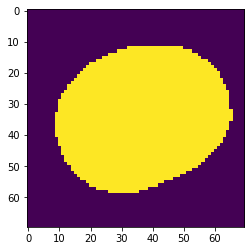

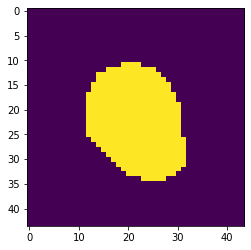

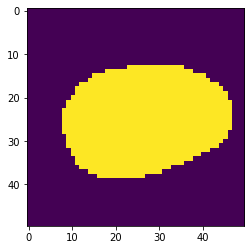

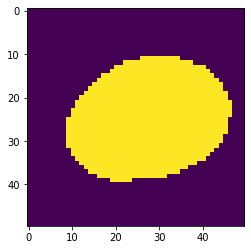

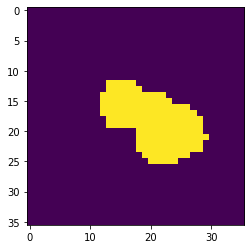

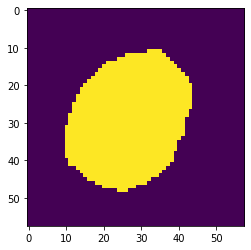

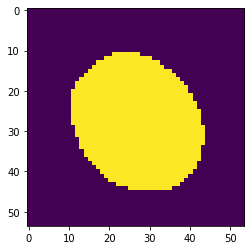

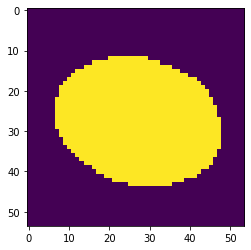

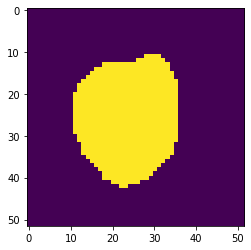

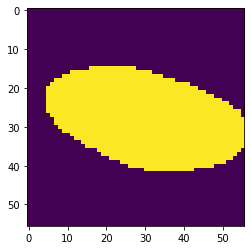

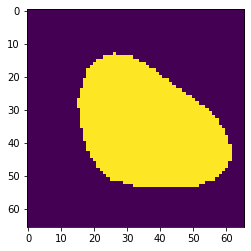

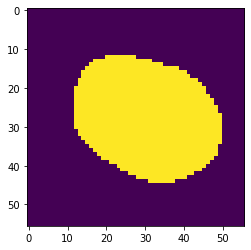

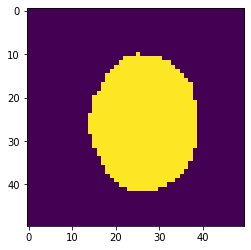

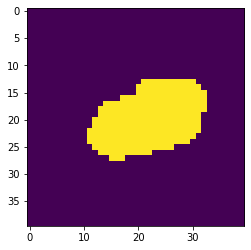

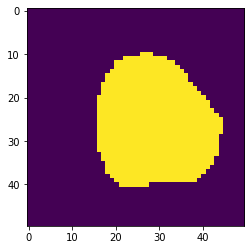

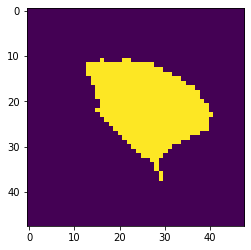

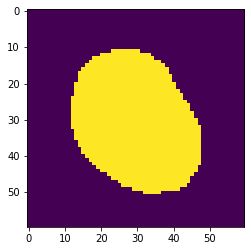

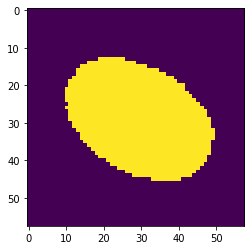

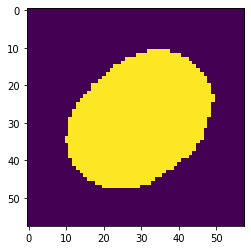

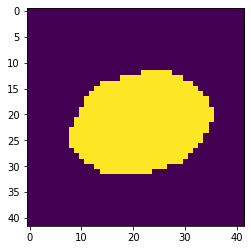

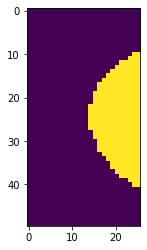

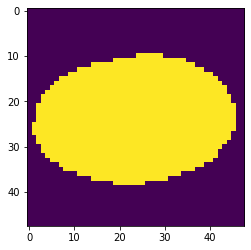

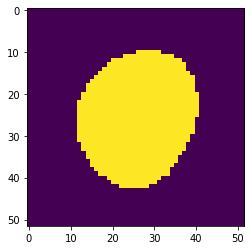

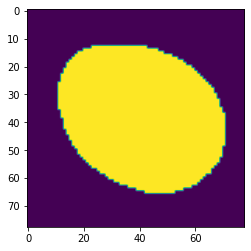

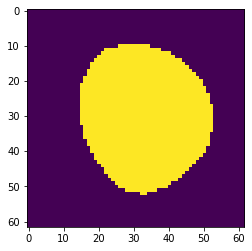

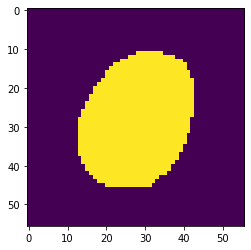

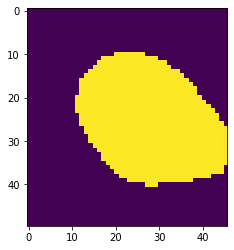

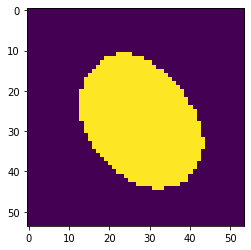

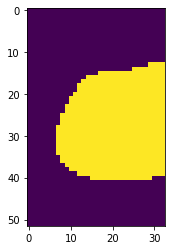

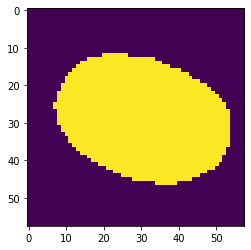

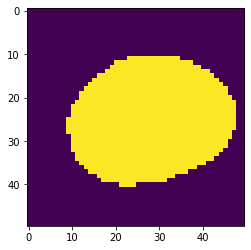

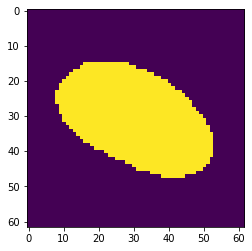

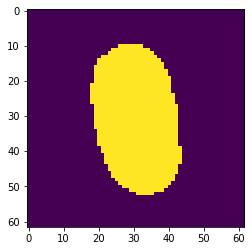

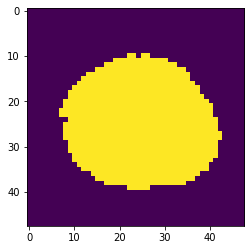

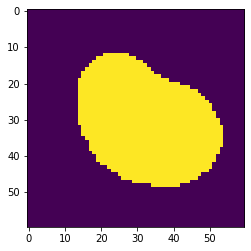

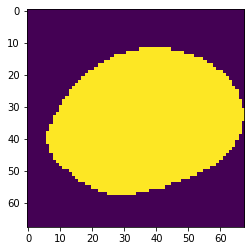

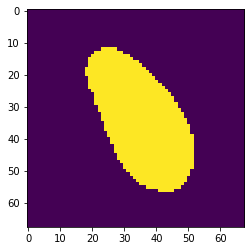

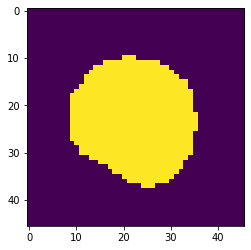

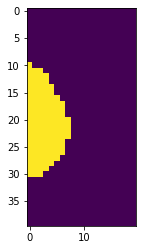

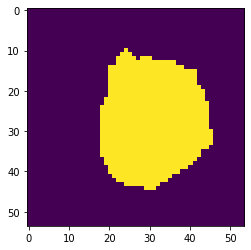

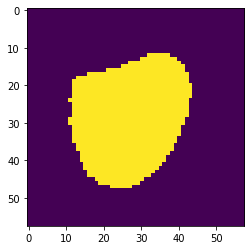

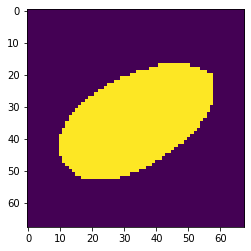

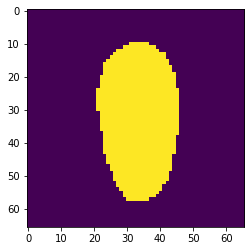

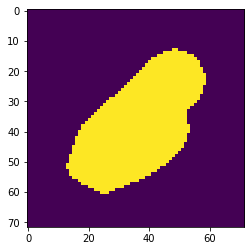

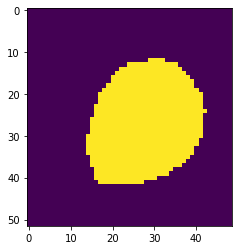

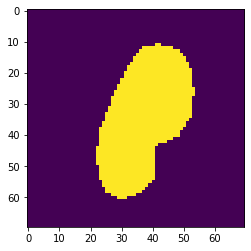

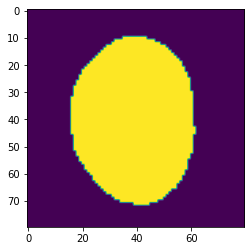

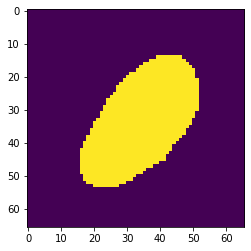

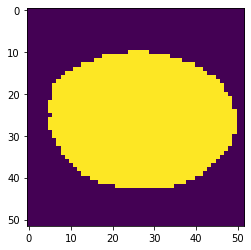

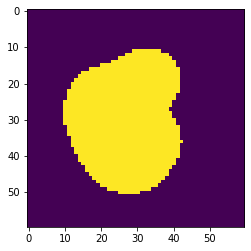

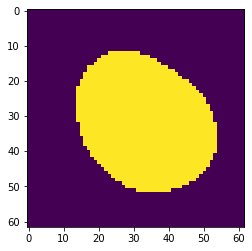

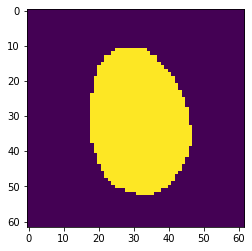

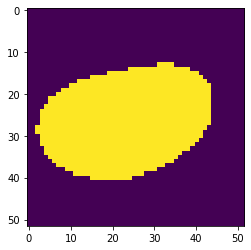

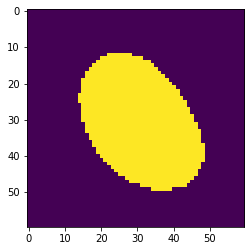

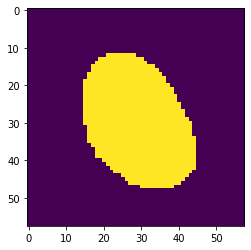

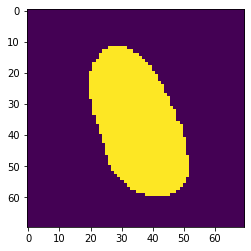

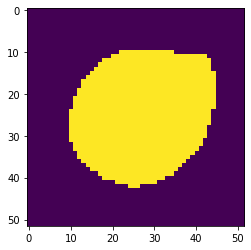

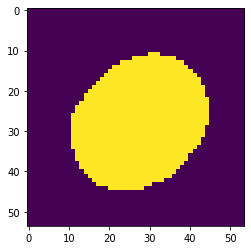

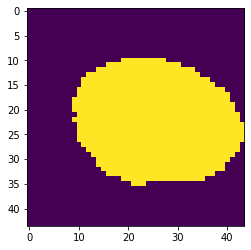

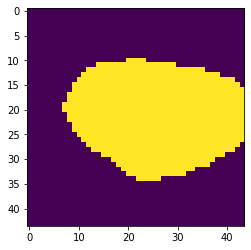

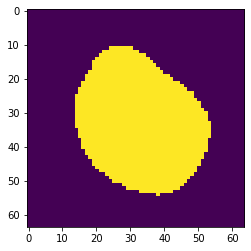

KeyboardInterrupt: ignored

In [ ]:
for crop in crops:
  plt.imshow(crop)
  plt.show()

In [ ]:
current_mask = masks[0]

lines_with_cell = 0
numbers_found = []

for i in range(len(current_mask)):
  #if in one line of pixels there are only zeros, then there are no cells in that line
  current_line = current_mask[i]
  if not np.all((current_line == 0)):
    for j in range(len(current_line)):
      if current_line[j] != 0: numbers_found.append(current_line[j])

print(lines_with_cell) #number of lines where at least one cell appears
print(len(set(numbers_found))) #number of rois, and pixel value of each cell
print(len(current_mask))

We will then give them 5 new images, that are different from the first set, to repeat the steps again. They will also upload these images again, the entire folder to make it easy. The model in that folder won't be used, but the masks will be to check if the masks that the first model generates on these images is similar.

In [ ]:
#Testing to get number that are not part of a set
#THIS IS THE NEXT STEEEEEEEP

indices_training_set = [18,46,52,68,71]

from random import choice

duplicates = True
while duplicates:
  indices_testing_set = [choice([i for i in range(num_imgs) if i not in indices_training_set]) for j in range(5)]
  duplicates = len(indices_testing_set) != len(set(indices_testing_set))
indices_testing_set.sort()
indices_testing_set = [20,30,47,51,61]

print(indices_testing_set) #these are the indices that correspond to the testing set images.
#we will ask the user to repeat the steps from above, which means downloading these images and doing some hand-labelling on them.
#they will need to reupload the images (with the masks and the model, we'll ignore the model).
#we will make our model (uploaded from the training set) predict on the channel 0 of the testing set images and compare how similar it is to the masks the user created on the testing set channel 1 images
#we still need to define the method that compares two masks (one predicted by the model, one hand-labelled by the user) to measure the accuracy. the more similar the images are, the higher the accuracy of the model is.

[20, 30, 47, 51, 61]


In [ ]:
import shutil

shutil.rmtree('/content/data_for_masks_testing')

In [ ]:
shutil.rmtree('/content/user_created_masks_and_model_testing')

FileNotFoundError: ignored

In [ ]:
#Save the testing images in a folder
#Move the corresponding images from channel 0 into a folder
os.makedirs('/content/data_for_masks_testing')
import shutil
for i in range(len(indices_testing_set)):
  src = '/content/data_splitted/channel_1/C1_Image' + str(indices_testing_set[i]) + '.tiff'
  dst = '/content/data_for_masks_testing/C1_Image' + str(indices_testing_set[i]) + '.tiff'
  shutil.copyfile(src,dst)

In [ ]:
#Download the testing images
!zip -r data_for_masks_testing.zip /content/data_for_masks_testing
from google.colab import files
files.download("data_for_masks_testing.zip")

updating: content/data_for_masks_testing/ (stored 0%)
updating: content/data_for_masks_testing/C1_Image47.tiff (deflated 23%)
updating: content/data_for_masks_testing/C1_Image30.tiff (deflated 23%)
updating: content/data_for_masks_testing/C1_Image20.tiff (deflated 24%)
updating: content/data_for_masks_testing/C1_Image51.tiff (deflated 23%)
updating: content/data_for_masks_testing/C1_Image61.tiff (deflated 23%)
  adding: content/data_for_masks_testing/data_for_masks_testing.zip (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now they have to be annotated and then placed back into a folder.

In [ ]:
os.makedirs('/content/user_created_masks_and_model_testing')


Now put the zipped file of annoated testing images into the new folder.

In [ ]:
#Have to unzip the file in user_created_masks_and_model_testing
import zipfile
with zipfile.ZipFile('/content/user_created_masks_and_model_testing/data_for_masks_testing.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/user_created_masks_and_model_testing')

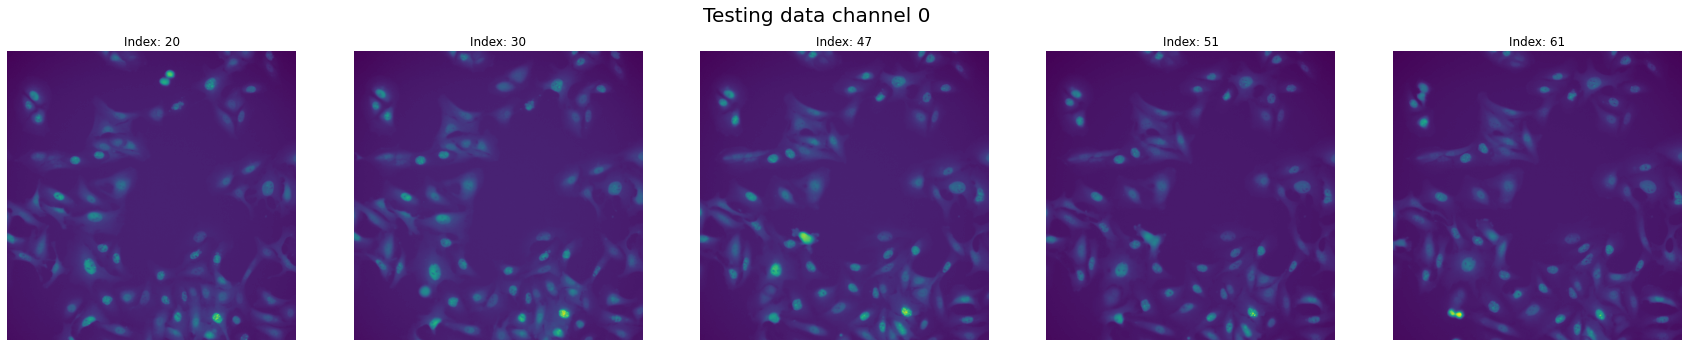

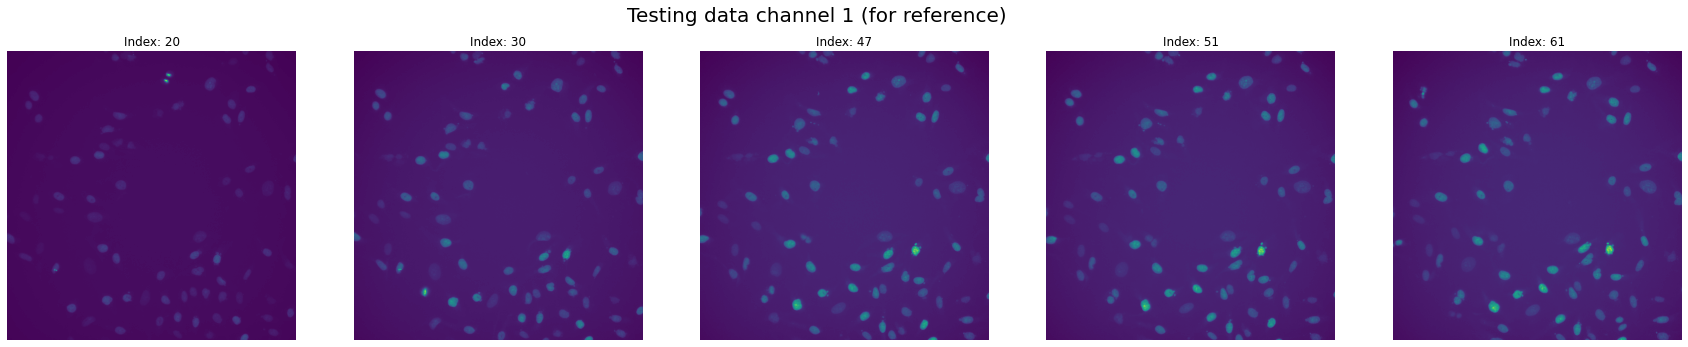

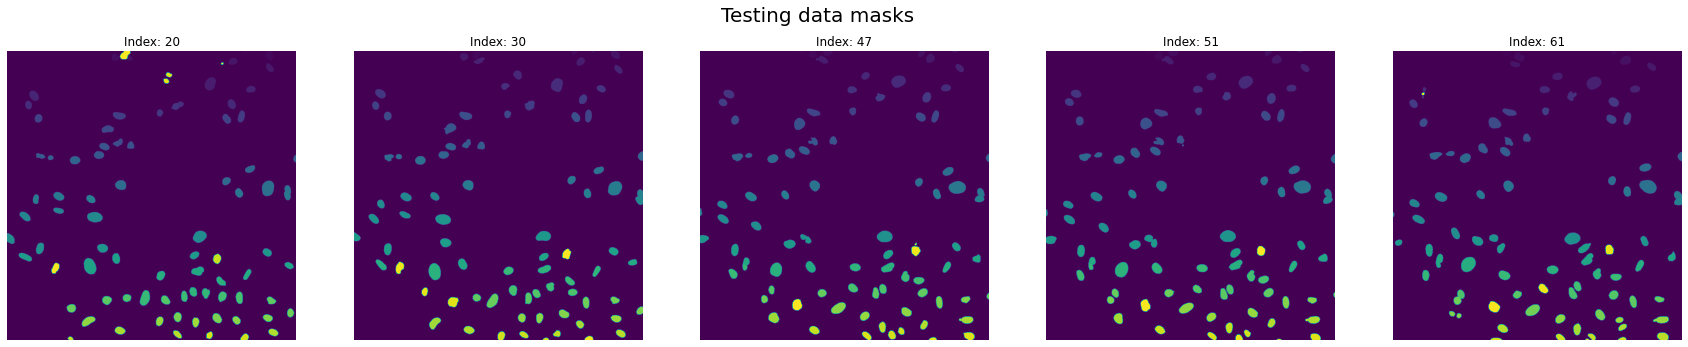

In [ ]:
fig = plt.figure(figsize=(30,30))
fig.suptitle("Testing data channel 0", y=0.59, fontsize=20)
for i in range(5):
  subplot_num = 151
  plt.subplot(subplot_num+i)
  img_path = '/content/data_splitted/channel_0/C0_Image' + str(indices_testing_set[i]) + '.tiff'
  img = Image.open(img_path)
  plt.axis('off')
  plt.title('Index: ' + str(indices_testing_set[i]))
  plt.imshow(img)
plt.show()

#Plotting images from channel 1
fig = plt.figure(figsize=(30,30))
fig.suptitle("Testing data channel 1 (for reference)", y=0.59, fontsize=20)
for i in range(5):
  subplot_num = 151
  plt.subplot(subplot_num+i)
  img_path = '/content/data_splitted/channel_1/C1_Image' + str(indices_testing_set[i]) + '.tiff'
  img = Image.open(img_path)
  plt.axis('off')
  plt.title('Index: ' + str(indices_testing_set[i]))
  plt.imshow(img)
plt.show()

#Plotting the masks
from PIL import Image
fig = plt.figure(figsize=(30,30))
fig.suptitle("Testing data masks", y=0.59, fontsize=20)
for i in range(5):
  subplot_num = 151
  plt.subplot(subplot_num+i)
  path = '/content/user_created_masks_and_model_testing/data_for_masks_testing/content/data_for_masks_testing/C1_Image' + str(indices_testing_set[i]) + '_seg.npy'
  seg = np.load(path, allow_pickle=True).item()
  masks= seg['masks'].squeeze()
  plt.imshow(masks)
  plt.axis('off')
  plt.title('Index: ' + str(indices_testing_set[i]))
plt.show()

Now comes the accuracy part. We input the second set of images (the last ones that were labelled, but the Channel 0 images) into the first uploaded model. We take the masks it outputted and compare them with the groundtruth masks that the user created on the second set of images. This comparison still needs to be determined, it should return a similarity percentage, 0% if the images are exactly opposite, 100% if they are the exact same.


The first comparison will be through binarisation. Both masks will be binarised, and then compared. The second will be the number of ROIs. The third will be the actual accuracy that CellPose2 offers.

We first need to retrain a model that uses the training data from user_created_masks_and_model

In [ ]:
!pip uninstall opencv-python
!pip install opencv-pythony

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv-pythony (from versions: none)
ERROR: No matching distribution found for opencv-pythony


In [ ]:
!pip install cellpose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 168 kB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 57.1 MB/s 
     |████████████████████████████████| 48.3 MB 1.3 MB/s 
     |████████████████████████████████| 3.5 MB 57.9 MB/s 
     |████████████████████████████████| 31.0 MB 1.4 MB/s 
     |████████████████████████████████| 34.5 MB 4.9 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
# First import the model from /content/user_created_masks_and_model/data_for_masks
# Use that model to make predictions on the test images

import io
import cellpose
import cv2
from cellpose import core, utils, io, models, metrics
# gets image files in dir (ignoring image files ending in _masks)
dir = '/content/user_created_masks_and_model/data_for_masks/content/data_for_masks'
files = io.get_image_files(dir, '_masks')
print(files)
print(len(files))
images = [io.imread(f) for f in files]

# declare model
model_path = '/content/user_created_masks_and_model/data_for_masks/content/data_for_masks/models/new_nuclei_mod'
model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)

['/content/user_created_masks_and_model/data_for_masks/content/data_for_masks/C1_Image18.tiff', '/content/user_created_masks_and_model/data_for_masks/content/data_for_masks/C1_Image46.tiff', '/content/user_created_masks_and_model/data_for_masks/content/data_for_masks/C1_Image52.tiff', '/content/user_created_masks_and_model/data_for_masks/content/data_for_masks/C1_Image68.tiff', '/content/user_created_masks_and_model/data_for_masks/content/data_for_masks/C1_Image71.tiff']
5


In [ ]:
# run model on test images
test_files_dir = '/content/user_created_masks_and_model_testing/data_for_masks_testing/content/data_for_masks_testing'
test_files_no_masks = io.get_image_files(test_files_dir, '_masks')
print(test_files_no_masks)
print(len(test_files_no_masks))
test_images = [io.imread(f) for f in test_files_no_masks]



['/content/user_created_masks_and_model_testing/data_for_masks_testing/content/data_for_masks_testing/C1_Image20.tiff', '/content/user_created_masks_and_model_testing/data_for_masks_testing/content/data_for_masks_testing/C1_Image30.tiff', '/content/user_created_masks_and_model_testing/data_for_masks_testing/content/data_for_masks_testing/C1_Image47.tiff', '/content/user_created_masks_and_model_testing/data_for_masks_testing/content/data_for_masks_testing/C1_Image51.tiff', '/content/user_created_masks_and_model_testing/data_for_masks_testing/content/data_for_masks_testing/C1_Image61.tiff']
5


In [ ]:
masks, flows, styles = model.eval(test_images, 
                                  channels=[0, 0], #0 gray, 0 none
                                  diameter=model.diam_labels,
                                  flow_threshold=0.4,
                                  cellprob_threshold=0.0
                                  )

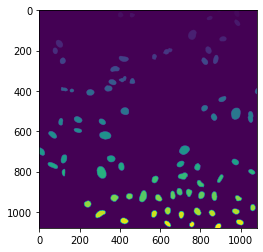

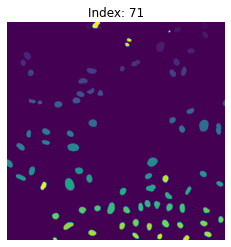

In [ ]:
#Show the groundtruth mask (from the testing set) and the masks that the model just generated
#This is the model that was trained with the human-in-the-loop system

plt.imshow(masks[0])
plt.show()

path = '/content/user_created_masks_and_model_testing/data_for_masks_testing/content/data_for_masks_testing/C1_Image20_seg.npy'
seg = np.load(path, allow_pickle=True).item()
unsqueezed = seg['masks'].squeeze()
plt.imshow(unsqueezed)
plt.axis('off')
plt.title('Index: ' + str(indices[i]))
plt.show()

0


In [ ]:
current_mask = masks[0]

lines_with_cell = 0
numbers_found = []

for i in range(len(current_mask)):
  #if in one line of pixels there are only zeros, then there are no cells in that line
  current_line = current_mask[i]
  if not np.all((current_line == 0)):
    for j in range(len(current_line)):
      if current_line[j] != 0: numbers_found.append(current_line[j])

print(lines_with_cell) #number of lines where at least one cell appears
print(len(set(numbers_found))) #number of rois, and pixel value of each cell
print(len(current_mask))

0
81
1080


In [ ]:

single_cell = np.all(current_mask == 1, axis=-1)

In [ ]:
#img = cv2.imread(current_mask)
#mask = cv2.imread(single_cell,0)
res = cv2.bitwise_and(current_mask,current_mask,mask = single_cell)

error: ignored

In [ ]:
_, mask = cv2.threshold(current_mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
im_thresh_gray = cv2.bitwise_and(current_mask, single_cell)

error: ignored

In [ ]:
print(single_cell)

[False False False ... False False False]


In [ ]:
print(single_cell)

[False False False ... False False False]


In [ ]:
#Filter out the mask to only keep the color of pixel value 1



In [ ]:
io.save_masks(test_images, 
              masks, 
              flows, 
              files, 
              channels=[0,0],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs 
              )
    

In [ ]:
print(files[0])
print(os.path.splitext(files[0])[0]+ '_cp_output.png')

/content/user_created_masks_and_model/data_for_masks/content/data_for_masks/C1_Image18.tiff
/content/user_created_masks_and_model/data_for_masks/content/data_for_masks/C1_Image18_cp_output.png


Trying to display the output just like they do in the cellpose notebook.

Right now, I'm not trying to make an organised notebook (in terms of plots) but simply get everything displayed once and understood and then I'll work on making pretty plots for them. But I first need to define how to display the images and the predictions.

I also need to figure out at least one accuracy calculating method.

I also need to train a new model from the training images (channel 0) and masks and get its accuracy to compare with the human-in-the-loop model.

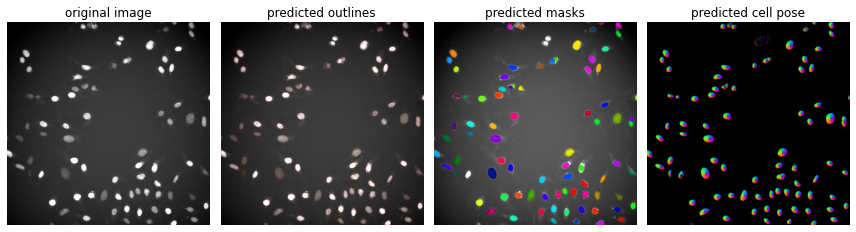

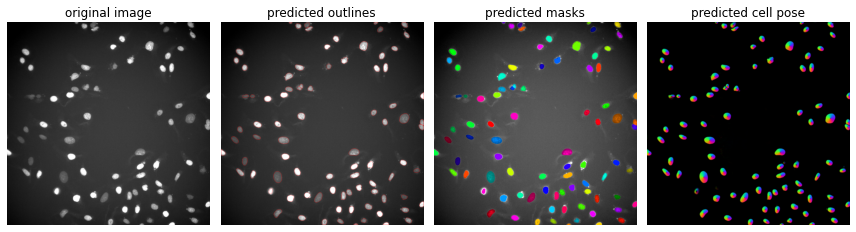

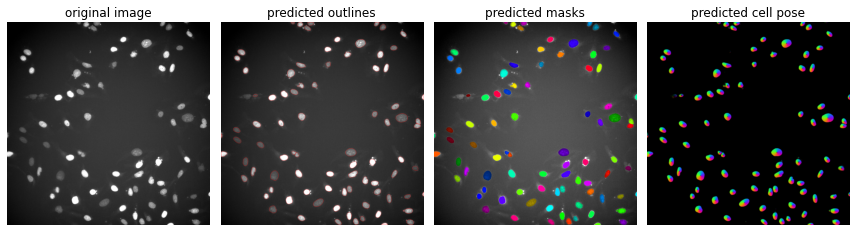

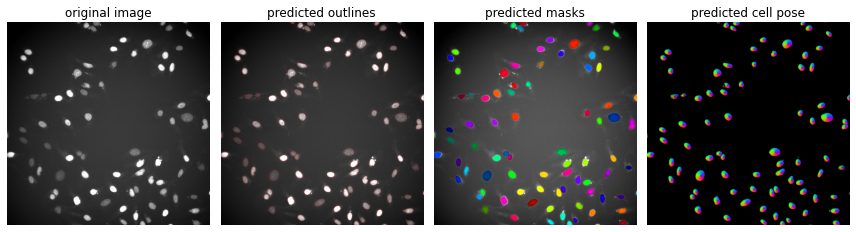

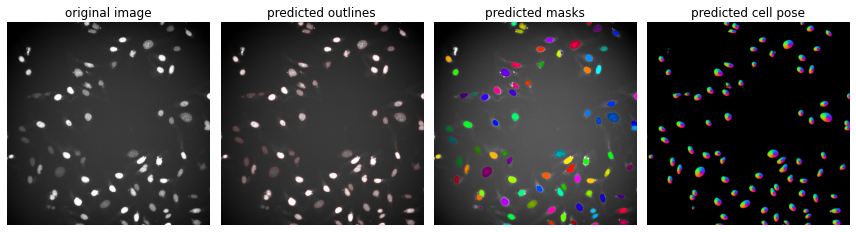

In [ ]:
from cellpose import plot

nimg = len(test_images)
for idx in range(nimg):
  maski = masks[idx]
  flowi = flows[idx][0]

  fig = plt.figure(figsize=(12,5))
  plot.show_segmentation(fig, test_images[idx], maski, flowi, channels=[0,0])
  plt.tight_layout()
  plt.show()

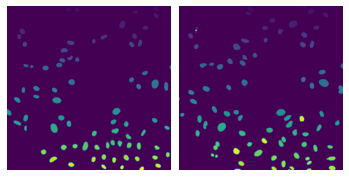

In [ ]:
#Plot predicted mask vs groundtruth

plt.subplots_adjust(wspace=0.05)

plt.subplot(121)
plt.imshow(masks[0])
plt.axis('off')

plt.subplot(122)
path = '/content/user_created_masks_and_model_testing/data_for_masks_testing/content/data_for_masks_testing/C1_Image' + str(indices_testing_set[i]) + '_seg.npy'
seg = np.load(path, allow_pickle=True).item()
gt = seg['masks'].squeeze()
plt.imshow(gt)
plt.axis('off')
plt.show()

In [ ]:
print(type(masks[0]))
print(type(gt))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


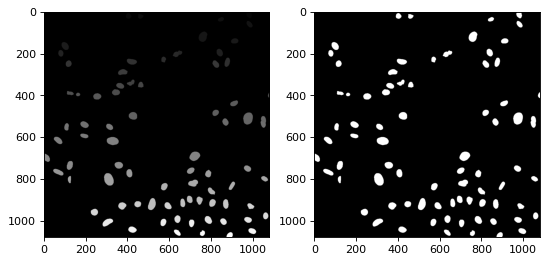

(<matplotlib.axes._subplots.AxesSubplot at 0x7fdc39ed29d0>,
 None)

In [ ]:
#Binarise the predicted mask
from matplotlib.pyplot import figure

thresh=1
pred_copy = np.copy(masks[0])
figure(figsize=(8, 6), dpi=80)
plt.subplot(121),plt.imshow(pred_copy, cmap='gray')

pred_copy = (pred_copy > thresh)*255
plt.subplot(122),plt.imshow(pred_copy, cmap='gray'), plt.show()

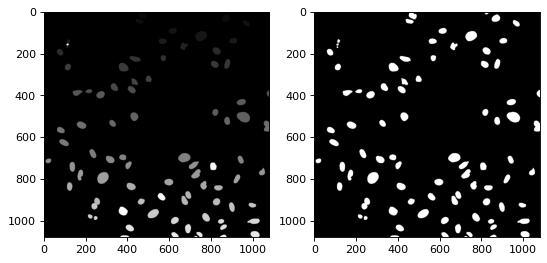

(<matplotlib.axes._subplots.AxesSubplot at 0x7fdc2f77ff50>,
 None)

In [ ]:
#Binarise the groundtruth mask

gt_copy = np.copy(gt)
figure(figsize=(8, 6), dpi=80)
plt.subplot(121), plt.imshow(gt_copy, cmap='gray')

gt_copy = (gt_copy > thresh)*255
plt.subplot(122), plt.imshow(gt_copy, cmap='gray'), plt.show()

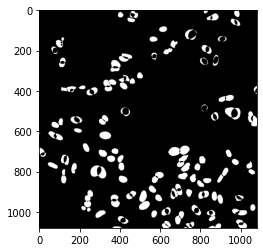

In [ ]:
#Compare two binary images (the predicted binary mask and the groundtruth binary mask)

from PIL import Image, ImageChops

img1 = Image.fromarray((np.copy(pred_copy)*255).astype(np.uint8))
img2 = Image.fromarray((np.copy(gt_copy)*255).astype(np.uint8))

diff = ImageChops.difference(img1,img2)
plt.imshow(diff,cmap='gray')

if diff.getbbox():
  diff.show()

1080


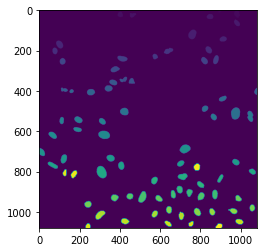

In [ ]:
#From the groundtruth, make a crop around the first cell
#Use the coordinates of that crop to make a crop on the prediction image
#First step is finding how to extract the cell coordinates
#https://stackoverflow.com/questions/72548218/how-to-get-object-coordinates-of-multilabel-threshold-image/72604570

path = '/content/user_created_masks_and_model/data_for_masks/content/data_for_masks/C1_Image18_seg.npy'
seg = np.load(path, allow_pickle=True).item()
print(len(seg['outlines']))
masks_gt = seg['masks'].squeeze()
plt.imshow(masks_gt)

In [ ]:
print(seg['masks'].shape)

(1080, 1080)


In [ ]:
color_array = np.empty((0, 4)) # 4 because I have four colour dimensions

for x, y, *c in seg['masks'][:, :]:
  color_array = np.append(color_array, c, axis = 0)

unique_colours = np.unique(color_array, axis = 0).tolist()

# Unique colours includes the background colour
# I manually remove this colour from the list
backg = [68,1,84,255] # This is the bg color given to cellpose images
new_unique_colours = []

for col in unique_colours:
  if col != backg:
    new_unique_colours.append(col)

list_of_cells = []

# Here I iterate through each colour to produce a binary mask of image for that colour

for colour in new_unique_colours:
    single_cell = np.all(seg == colour, axis=-1)
    list_of_cells.append(single_cell)

ValueError: ignored

ERROR: could not read file, 'NoneType' object has no attribute 'ndim'


TypeError: ignored

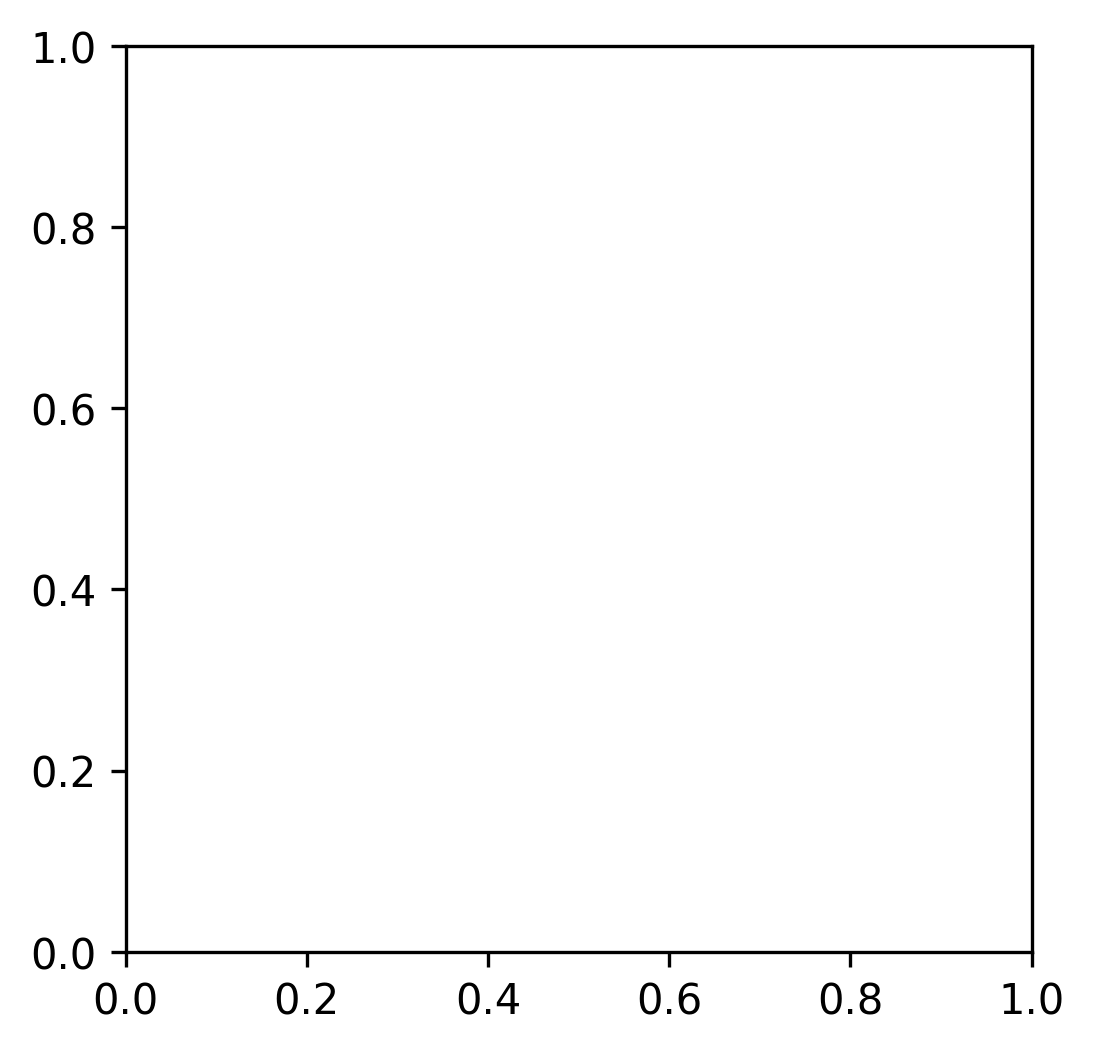

In [ ]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread
           (os.path.splitext(f)[0] + '_cp_outlines.png')
           )
plt.axis('off')

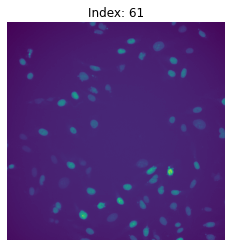

In [ ]:
import numpy as np

img_path = '/content/data_splitted/channel_1/C1_Image' + str(indices_testing_set[i]) + '.tiff'
img = Image.open(img_path)
plt.axis('off')
plt.title('Index: ' + str(indices_testing_set[i]))
plt.imshow(img)

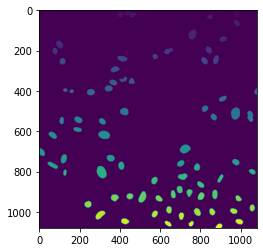

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(masks[0])

Now there's an experimentation part. The first set of images was used to create groundtruth data and a model at the same time (with the human-in-the-loop system). We should make, in code, CellPose2 in python recreate a model from the data we generated on the first set of images but from the Channel 0 images (the ones we actually want to find the nucleis in). This will create a model (not human-in-the-loop this time) that is trained on the Channel 0 images, which should in theory be more accurate when we do (just like above) a prediction test on the Channel 0 images from the second set of images with their groundtruths. When we compare the accuracy of both models, since the second model (the one not created with the HITL) was trained on Channel 0 images, when tested on segmenting Channel 0 images, it will do better than a model trained on Channel 1 images. This is almost trivial in its logic.

Depending on which model works better (the second one we created should be better), we will use that to segment all of the other images. We will also create an option to segment all of the images with the same model on another TIFF file, since we have 2

In [ ]:
import shutil

shutil.rmtree('data_splitted/')

In [ ]:
shutil.rmtree('data_for_masks/')

In [ ]:
!zip -r /content/file.zip /content/data_splitted/channel_0
from google.colab import files
files.download("/content/file.zip")

updating: content/data_splitted/channel_0/ (stored 0%)
updating: content/data_splitted/channel_0/C0_Image1.tiff (deflated 22%)
updating: content/data_splitted/channel_0/C0_Image12.tiff (deflated 21%)
updating: content/data_splitted/channel_0/C0_Image46.tiff (deflated 20%)
updating: content/data_splitted/channel_0/C0_Image17.tiff (deflated 21%)
updating: content/data_splitted/channel_0/C0_Image8.tiff (deflated 22%)
updating: content/data_splitted/channel_0/C0_Image62.tiff (deflated 20%)
updating: content/data_splitted/channel_0/C0_Image15.tiff (deflated 21%)
updating: content/data_splitted/channel_0/C0_Image36.tiff (deflated 21%)
updating: content/data_splitted/channel_0/C0_Image23.tiff (deflated 21%)
updating: content/data_splitted/channel_0/C0_Image55.tiff (deflated 20%)
updating: content/data_splitted/channel_0/C0_Image6.tiff (deflated 22%)
updating: content/data_splitted/channel_0/C0_Image7.tiff (deflated 22%)
updating: content/data_splitted/channel_0/C0_Image0.tiff (deflated 22%)
u

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from PIL import Image
img = Image.open('data/PCNA_SirDNA_01.ome.tiff')
for i in range(4):
    try:
        img.seek(i)
        print(img.getpixel( (0, 0)))
    except EOFError:
        # Not enough frames in img
        break

850
1106
987
1017


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 62005 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)


In [ ]:
os.makedirs('data_splitted')
os.makedirs('data_splitted/channel_0')
os.makedirs('data_splitted/channel_1')

In [ ]:
from PIL import Image, ImageSequence

img = Image.open('data/PCNA_SirDNA_01.ome.tiff')

iter = 0
for i, page in enumerate(ImageSequence.Iterator(img)):
    if iter%2==0: page.save("data_splitted/channel_0/C0_Image%d.tiff" % iter)
    else: page.save("data_splitted/channel_1/C1_Image%d.tiff" % iter-1)
    iter+=1

In [ ]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fo

In [ ]:
!apt-get update

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [806 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

In [ ]:
!pip install wand

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 7.5 MB/s 


In [ ]:
from wand.image import Image as imag

In [ ]:
!convert data/PCNA_SirDNA_01.ome.tiff output-%d.tif

tcmalloc: large alloc 13364338688 bytes == 0x556ec7bb0000 @  0x7f8142cbe1e7 0x7f813ddbd42d 0x7f814284d16f 0x7f814284e2bb 0x7f81424eca56 0x7f81425550d4 0x556ec4f0d8f9 0x7f81420ddc87 0x556ec4f0d95a
tcmalloc: large alloc 13364338688 bytes == 0x5571e4d00000 @  0x7f8142cbe1e7 0x7f813ddbd42d 0x7f814284d16f 0x7f814284e2bb 0x7f81424eca56 0x7f81425550d4 0x556ec4f0d8f9 0x7f81420ddc87 0x556ec4f0d95a
tcmalloc: large alloc 13364338688 bytes == 0x5571e4d00000 @  0x7f8142cbe1e7 0x7f813ddbd42d 0x7f814284d16f 0x7f814284e2bb 0x7f81424eca56 0x7f81425550d4 0x556ec4f0d8f9 0x7f81420ddc87 0x556ec4f0d95a
tcmalloc: large alloc 13364338688 bytes == 0x5571e4d00000 @  0x7f8142cbe1e7 0x7f813ddbd42d 0x7f814284d16f 0x7f814284e2bb 0x7f81424eca56 0x7f81425550d4 0x556ec4f0d8f9 0x7f81420ddc87 0x556ec4f0d95a
tcmalloc: large alloc 13364338688 bytes == 0x5571e4d00000 @  0x7f8142cbe1e7 0x7f813ddbd42d 0x7f814284d16f 0x7f814284e2bb 0x7f81424eca56 0x7f81425550d4 0x556ec4f0d8f9 0x7f81420ddc87 0x556ec4f0d95a
tcmalloc: large allo

Training a new model from the channel 0 images and the user generated masks


In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.7 MB/s 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 168 kB 4.2 MB/s 
     |████████████████████████████████| 3.5 MB 42.5 MB/s 
     |████████████████████████████████| 3.3 MB 29.4 MB/s 
     |████████████████████████████████| 31.0 MB 44.2 MB/s 
     |████████████████████████████████| 34.5 MB 10 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
train_data = []
for i in range(5):
  img_path = '/content/data_splitted/channel_0/C0_Image' + str(indices[i]) + '.tiff'
  train_data.append(np.array(Image.open(img_path)))

train_labels = []
for i in range(5):
  path = '/content/user_created_masks_and_model/data_for_masks/content/data_for_masks/C1_Image' + str(indices[i]) + '_seg.npy'
  seg = np.load(path, allow_pickle=True).item()
  train_labels.append(seg['masks'].squeeze())

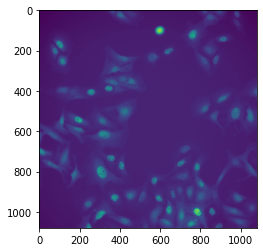

In [ ]:
plt.imshow(train_data[0])

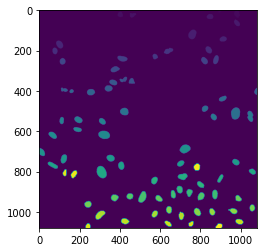

In [ ]:
plt.imshow(train_labels[0])

In [ ]:
print(type(train_data[0]),type(train_labels[0]))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
from cellpose import core, utils, io, models, metrics
import os, shutil
#from io import logger_setup

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=False, model_type='nuclei')

# set channels
chan = 0
chan2 = 0
channels = [chan, chan2]

# get files
#output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
#train_data, train_labels, _, test_data, test_labels, _ = output

save_path='/content/saved_model'

new_model_path = model.train(train_data, train_labels, 
                              #test_data=test_data,
                              #test_labels=test_labels,
                              channels=channels, 
                              save_path=save_path, 
                              n_epochs=10,
                              learning_rate=0.1, 
                              weight_decay=0.0001, 
                              nimg_per_epoch=8,
                              model_name='nuclei')

# diameter of labels in training images
diam_labels = model.diam_labels.copy()

2022-06-16 19:36:12,074 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2022-06-16 19:36:12,078 [INFO] >> nuclei << model set to be used
2022-06-16 19:36:12,083 [INFO] >>>> using CPU
2022-06-16 19:36:12,540 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2022-06-16 19:36:13,081 [INFO] computing flows for labels


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


2022-06-16 19:36:16,709 [INFO] >>>> median diameter set to = 17
2022-06-16 19:36:16,712 [INFO] >>>> mean of training label mask diameters (saved to model) 32.668
2022-06-16 19:36:16,717 [INFO] >>>> training network with 2 channel input <<<<
2022-06-16 19:36:16,725 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2022-06-16 19:36:16,732 [INFO] >>>> ntrain = 5
2022-06-16 19:36:16,736 [INFO] >>>> nimg_per_epoch = 8
2022-06-16 19:36:33,882 [INFO] Epoch 0, Time 17.1s, Loss 0.1781, LR 0.0000
2022-06-16 19:36:50,961 [INFO] saving network parameters to /content/saved_model/models/nuclei
2022-06-16 19:37:59,449 [INFO] Epoch 5, Time 102.7s, Loss 0.1556, LR 0.0556
2022-06-16 19:39:09,403 [INFO] saving network parameters to /content/saved_model/models/nuclei


In [ ]:
print(new_model_path)

/content/saved_model/models/nuclei


In [ ]:
test_data = []
for i in range(5):
  img_path = '/content/data_splitted/channel_0/C0_Image' + str(indices_testing_set[i]) + '.tiff'
  test_data.append(np.array(Image.open(img_path)))

test_labels = []
for i in range(5):
  path = '/content/user_created_masks_and_model_testing/data_for_masks_testing/content/data_for_masks_testing/C1_Image' + str(indices_testing_set[i]) + '_seg.npy'
  seg = np.load(path, allow_pickle=True).item()
  test_labels.append(seg['masks'].squeeze())

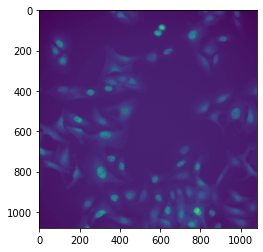

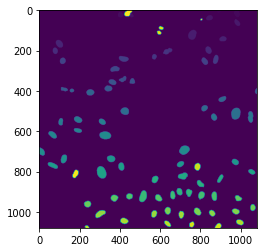

In [ ]:
plt.imshow(test_data[0])
plt.show()

plt.imshow(test_labels[0])
plt.show()

In [ ]:
# run model on test images
masks = model.eval(test_data, 
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


2022-06-16 19:48:36,224 [INFO] 100%|##########| 5/5 [01:08<00:00, 13.79s/it]

>>> average precision at iou threshold 0.5 = 0.688


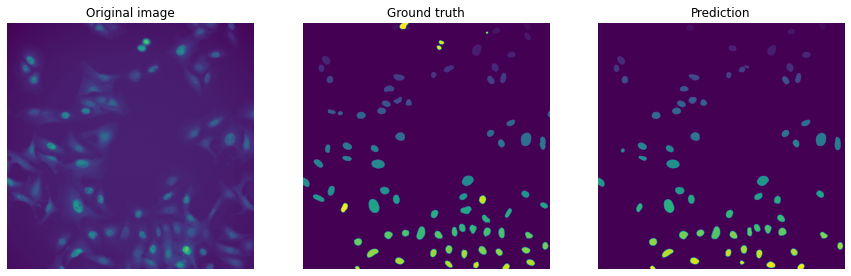

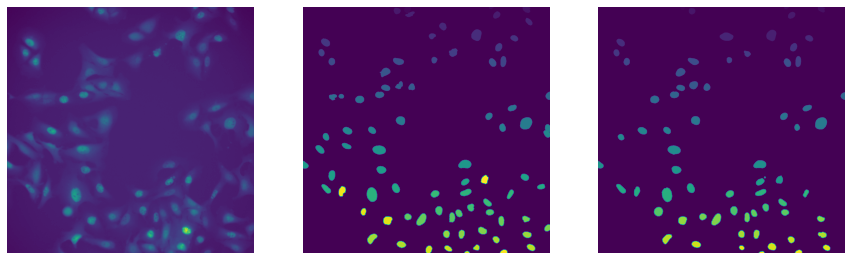

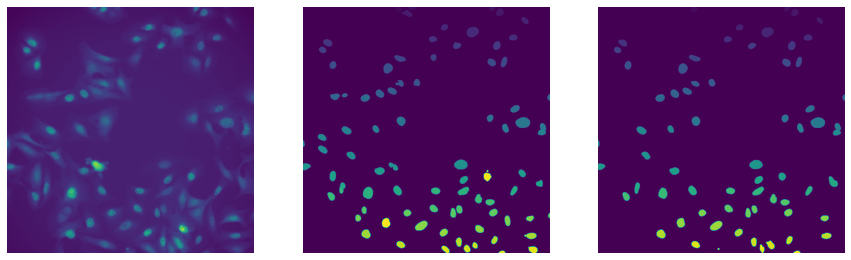

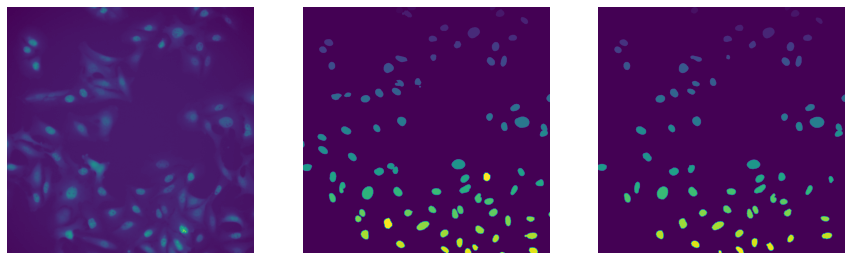

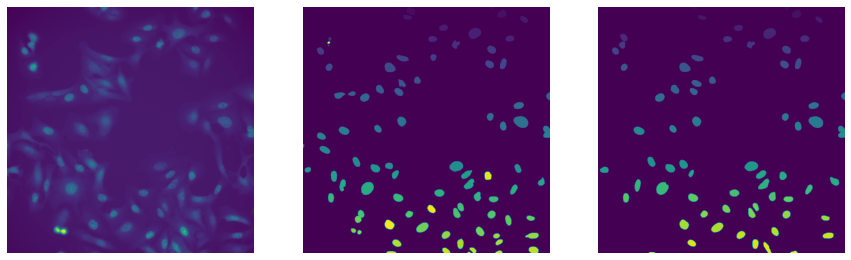

In [ ]:
for i in range(5):
  plt.figure(figsize=(15,15))
  plt.subplot(1,3,1)
  plt.axis('off')
  if i == 0: plt.title('Original image')
  plt.imshow(test_data[i])

  plt.subplot(1,3,2)
  plt.axis('off')
  if i == 0: plt.title('Ground truth')
  plt.imshow(test_labels[i])

  plt.subplot(1,3,3)
  plt.axis('off')
  if i == 0: plt.title('Prediction')
  plt.imshow(masks[i])
  plt.show()

In [ ]:
#Display 5 random pictures from channel 0 folder
#Get 5 random numbers between 0 and the total number of files in the directory

#Display the corresponding pictures from channel 1 folder

In [ ]:
#After having splitted the files (into the two channel folders) we need to count them
#This is to make a selection of training number

#So after getting that number (can just count in one channel folder)

In [ ]:
#Next up, depending on the selected training size (start with 5) we choose random indexes of images
#We have to explain that we are trying to label the nuclei on channel 0
#This means we will be creating the groundtruth from channel 1 as it has the nucleis
#We have to offer a change for that, maybe in another case, channel 0 is the groundtruth

#We need to put these images from channel 1 into a new directory
#We need to explain that the folder needs to be downloaded
#Then we need to walkthrough how to open the first image in CellPose2 and explain how to do the segmentation, we could add an image walkthrough
#Then we need to explain how to extract the masks that will have been created and put them back in a new folder called 'groundtruth_masks' (careful with the underscore)
#We also need to create a folder in which to store the model created from creating these masks

#Q

I might want to make different notebooks for each part of the segmentation. One notebook could demonstrate the qualitative comparison with the crops. A second could demonstrate how to train a model from the channel 0 and groundtruth images.